In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import special, interpolate, stats
import mpmath
from IPython.display import clear_output

# PHYS 642: Problem Set #3: Monte Carlo Compton Scattering

## Part 1. Inverse Compton scattering for a single scattering

### a)

The probability distribution for the angle $\theta_i$ of an incoming photon relative to the direction of the electron's motion is proportional to $1-\beta \cos\theta_i$. Thus, a $\mu$ value must be chosen from

$$
P(\mu)\ d\mu = (1-\beta\mu)\ d\mu, \quad \text{where}\ \mu = \cos\theta_i.
$$

To generate appropriate $\mu$ values for this probability distribution, first define another variable $y$.

$$
y = -\frac{(1-\beta\mu)^2}{2\beta} \quad \Rightarrow \quad dy = (1-\beta\mu)\ d\mu
$$

So, to generate the correct probability distribution of incoming photon angles, we want to choose $y$ from a uniform distribution from $(1-\beta)^2/2\beta$ to $(1+\beta)^2/2\beta$ and then get $\mu$.

$$
\mu = \frac{1-\sqrt{2\beta y}}{\beta}
$$

In [2]:
def get_mu_labframe(beta, N):
    # y comes from a uniform distribution between 0.5*(1-beta)^2/beta and 0.5*(1+beta)^2/beta
    y = np.random.uniform(0.5*(1-beta)**2/beta, 0.5*(1+beta)**2/beta, N)
    # Calculate the corresponding mu value
    mu = (1-np.sqrt(2*beta*y))/beta
    return mu

The energy of the incoming photon in the electron's rest frame is given by the relativistic Doppler shift formula:

$$
E_i' = E_i \gamma (1-\beta \mu)
$$

The scattering angle in the electron rest frame $\theta_f'$ is assumed to be isotropic, so we must choose $\mu' = \cos\theta_f'$ from a uniform distribution between -1 and 1. Also, the scattering is assumed to be elastic so $E_i' = E_f'$.

Then, we can transform the scattered photon energy into the lab frame as follows:

$$
E_f = E_f' \gamma (1+\beta \mu').
$$

Let's code up this algorithm for a Monte Carlo simulation!

In [3]:
def inverse_Compton_MC(lorentz, Ei=1, niter=100000):
    '''
    Monte Carlo simluation for the spectrum from a single inverse Compton scattering.
    Takes the Lorentz factor (gamma), the initial photon energy (default=1), and the number of iterations to simulation (default=10^5) as inputs.
    Returns an array holding the final photon energy of each simulation as an output.
    '''
    # Calculate the beta=v/c from the input Lorentz factor.
    beta = np.sqrt(1-1/lorentz**2) 
    
    E = np.zeros(niter)
    for i in range(niter):
        # Choose a random photon direction in the lab frame.
        mu = get_mu_labframe(beta, 1)
        # Calculate the energy of the incident photon in the electron's rest frame.
        Ei_rest = Ei*lorentz*(1-beta*mu)
        # The scattering is assumed to be elastic in the electron rest frame.
        Ef_rest = Ei_rest
        # The scattered photon is emitted isotropically from the electron in its rest frame.
        mu_rest = np.random.uniform(-1,1)
        # Calculate the scattered photon's energy in the lab frame.
        Ef = Ef_rest*lorentz*(1+beta*mu_rest)
        E[i] = Ef   
    return E

Now, let's see the resulting spectrum for a Monte Carlo simulation of with initial photons of energy $E_i = 1$ and $\gamma = 50$.

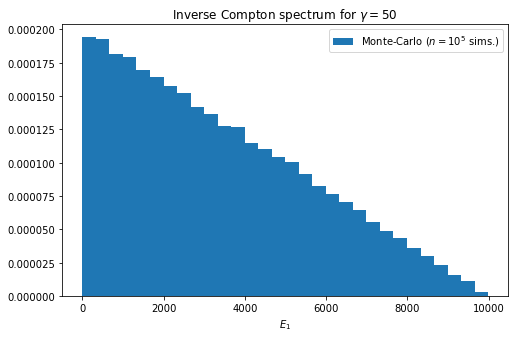

In [4]:
E0 = 1
Gamma = 50

MC_distribution = inverse_Compton_MC(Gamma, Ei=E0)

figA = plt.figure(figsize=(8,5))
plt.hist(MC_distribution, density=True, bins=30, label=r'Monte-Carlo ($n=10^5$ sims.)')
plt.title(r'Inverse Compton spectrum for $\gamma={:.0f}$'.format(Gamma))
plt.xlabel(r'$E_1$')
plt.legend()
plt.show()

## b)

Compare the spectrum obtained in part a) to the analytic result from Rybick and Lightman for Lorentz factors of $\gamma = 1.1, 5, 10, 50$.

In [5]:
def inverse_Compton_analytic(lorentz, E0=1):
    beta = np.sqrt(1-1/lorentz**2)
    E1_values = np.linspace(E0*(1-beta)/(1+beta), E0*(1+beta)/(1-beta), 200)
    j = np.asarray([(1+beta)*kk/E0 - (1-beta) if kk <= 1 else (1+beta) - kk/E0*(1-beta) for kk in E1_values])/(4*E0*beta**2*lorentz**2)
    return E1_values, j

In [6]:
Gamma0 = 1.1
MC0 = inverse_Compton_MC(Gamma0)
E1_values0, analytic0 = inverse_Compton_analytic(Gamma0)

Gamma1 = 5
MC1 = inverse_Compton_MC(Gamma1)
E1_values1, analytic1 = inverse_Compton_analytic(Gamma1)

Gamma2 = 10
MC2 = inverse_Compton_MC(Gamma2)
E1_values2, analytic2 = inverse_Compton_analytic(Gamma2)

Gamma3 = 50
MC3 = inverse_Compton_MC(Gamma3)
E1_values3, analytic3 = inverse_Compton_analytic(Gamma3)

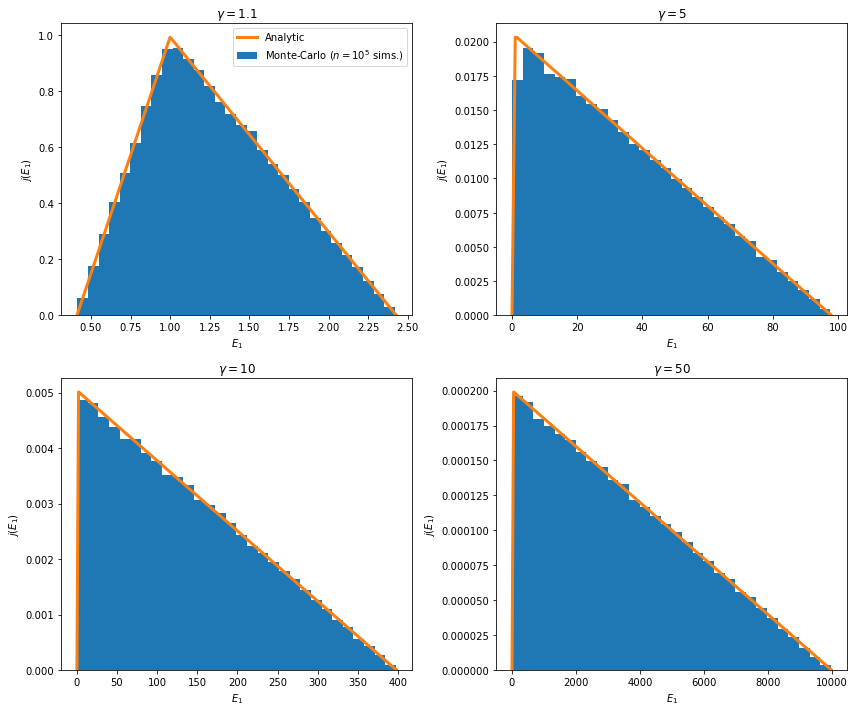

In [7]:
figB, axs = plt.subplots(2, 2, figsize=(12,10))
axs[0,0].hist(MC0, density=True, bins=30, label=r'Monte-Carlo ($n=10^5$ sims.)')
axs[0,0].plot(E1_values0, analytic0, lw=3, label='Analytic')
axs[0,0].set_title(r'$\gamma={:.1f}$'.format(Gamma0))
axs[0,0].set_xlabel(r'$E_1$')
axs[0,0].set_ylabel(r'$j(E_1)$')
axs[0,0].legend()

axs[0,1].hist(MC1, density=True, bins=30, label=r'Monte-Carlo ($n=10^5$ sims.)')
axs[0,1].plot(E1_values1, analytic1, lw=3, label='Analytic')
axs[0,1].set_title(r'$\gamma={:.0f}$'.format(Gamma1))
axs[0,1].set_xlabel(r'$E_1$')
axs[0,1].set_ylabel(r'$j(E_1)$')

axs[1,0].hist(MC2, density=True, bins=30, label=r'Monte-Carlo ($n=10^5$ sims.)')
axs[1,0].plot(E1_values2, analytic2, lw=3, label='Analytic')
axs[1,0].set_title(r'$\gamma={:.0f}$'.format(Gamma2))
axs[1,0].set_xlabel(r'$E_1$')
axs[1,0].set_ylabel(r'$j(E_1)$')

axs[1,1].hist(MC3, density=True, bins=30, label=r'Monte-Carlo ($n=10^5$ sims.)')
axs[1,1].plot(E1_values3, analytic3, lw=3, label='Analytic')
axs[1,1].set_title(r'$\gamma={:.0f}$'.format(Gamma3))
axs[1,1].set_xlabel(r'$E_1$')
axs[1,1].set_ylabel(r'$j(E_1)$')
plt.tight_layout()
plt.show()

### c)

For Thomson scattering, we choose the incident photon direction in the same manner as above. However, we'll need to transform the incident photon angle $\theta_i$ into the electron rest frame for use later on.

$$
\theta_i' = \frac{\cos\theta_i + beta}{1 + \beta \cos\theta_i}
$$

Now, the scattering angle $\alpha$ is proportional to $1+\cos^2{\alpha}$ and must be chosen from a different probability distribution.

$$
P(z)\ dz = (1+z^2)\ dz, \quad \text{where}\ z = \cos\alpha.
$$

To do this, we can use the rejection method, whereby 2 randomly distributed variables $x$ and $z$ are compared to one another before deciding whether or not to keep $z$. $x$ is randomly generated from a uniform distribution between 0 and 2, and $z$ is randomly generated from a uniform distribution between -1 and 1. If $x < 1+z^2$, then we keep the value of $z$, which is equal to $\cos\alpha$. Otherwise, we try again until appropriate $x$ and $z$ values are generated.

In [8]:
def get_cos_alpha(N):
    x = np.random.uniform(0,2,N)
    z = np.random.uniform(-1,1,N)
    idx = x >= 1 + z**2
    new_N = np.sum(idx)
    while new_N > 0:
        new_x = np.random.uniform(0,2,new_N)
        new_z = np.random.uniform(-1,1,new_N)
        x[idx] = new_x
        z[idx] = new_z
        idx = x >= 1 + z**2
        new_N = np.sum(idx)
    return z

The scattered photon will directed on a cone of angle $\alpha$ relative to the incoming photon direction. It can be directed at any angle $\phi$ around the cone, so $\phi$ must be randomly chosen from a uniform distribution between 0 and $2\pi$.

From the geometry of the problem, the direction of the scattered photon in the electron rest frame $\mu'$ is given by

$$
\mu' = \cos\theta_f' = \cos\alpha \cos\theta_i' - \sin\theta_i'.
$$

Here is what the Monte Carlo simulation for Thomson scattering looks like:

In [9]:
def Thomson_MC(lorentz, Ei=1, niter=100000):
    '''
    Monte Carlo simluation for the spectrum from a single Thomson scattering.
    Takes the Lorentz factor (gamma), the initial photon energy (default=1), and the number of iterations to simulation (default=10^5) as inputs.
    Returns an array holding the final photon energy of each simulation as an output.
    '''
    # Calculate the beta=v/c from the input Lorentz factor.
    beta = np.sqrt(1-1/lorentz**2)
    
    E = np.zeros(niter)
    for i in range(niter):
        # Choose a random photon direction in the lab frame.
        mu = get_mu_labframe(beta, 1)
        theta = np.arccos(mu)
        # Transform the incoming photon angle in the electron rest frame.
        cos_theta_rest = (mu+beta)/(1+beta*mu)
        theta_rest = np.arccos(cos_theta_rest)
        # Calculate the energy of the incident photon in the electron's rest frame.
        Ei_rest = Ei*lorentz*(1-beta*mu)
        # The scattering is assumed to be elastic in the electron rest frame.
        Ef_rest = Ei_rest
        # Get the scattering angle (alpha) using the rejection method.
        cos_alpha = get_cos_alpha(1)
        alpha = np.arccos(cos_alpha)
        # Choose a random uniformly distributed value for phi between 0 and 2pi.
        phi = np.random.uniform(0,2*np.pi)
        # Calculate mu in the electron rest frame.
        mu_rest = cos_alpha*cos_theta_rest - np.sin(theta_rest)*np.sin(alpha)*np.cos(phi)
        # Calculate the scattered photon's energy in the lab frame.
        Ef = Ef_rest*lorentz*(1+beta*mu_rest)
        E[i] = Ef   
    return E

Now, let's see the resulting Thomson scattering spectrum for a Monte Carlo simulation with initial photons of energy $E_i = 1$ and $\gamma = 50$.

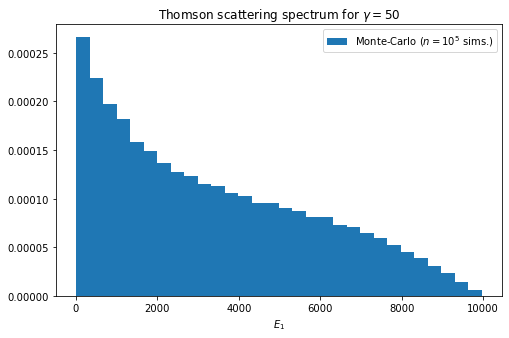

In [10]:
E0 = 1
Gamma = 50

Thomson_MC_distribution = Thomson_MC(Gamma, Ei=E0)

figC = plt.figure(figsize=(8,5))
plt.hist(Thomson_MC_distribution, density=True, bins=30, label=r'Monte-Carlo ($n=10^5$ sims.)')
plt.title(r'Thomson scattering spectrum for $\gamma={:.0f}$'.format(Gamma))
plt.xlabel(r'$E_1$')
plt.legend()
plt.show()

### d)

Compare the Thomson scattering spectrum obtained in part c) to the analytic result from Rybick and Lightman for Lorentz factors of $\gamma = 5, 10, 50, 100$.

In [11]:
def Thomson_analytic(lorentz, E0=1):
    beta = np.sqrt(1-1/lorentz**2)
    E1_values = np.linspace(E0*(1-beta)/(1+beta), E0*(1+beta)/(1-beta), 200)
    x = E1_values/(4*lorentz**2*E0)
    j = 3/(4*lorentz**2*E0)*(2*x*np.log(x)+x+1-2*x**2)
    return E1_values, j

In [12]:
Gamma0 = 5
MC0 = Thomson_MC(Gamma0)
E1_values0, analytic0 = Thomson_analytic(Gamma0)

Gamma1 = 10
MC1 = Thomson_MC(Gamma1)
E1_values1, analytic1 = Thomson_analytic(Gamma1)

Gamma2 = 50
MC2 = Thomson_MC(Gamma2)
E1_values2, analytic2 = Thomson_analytic(Gamma2)

Gamma3 = 100
MC3 = Thomson_MC(Gamma3)
E1_values3, analytic3 = Thomson_analytic(Gamma3)

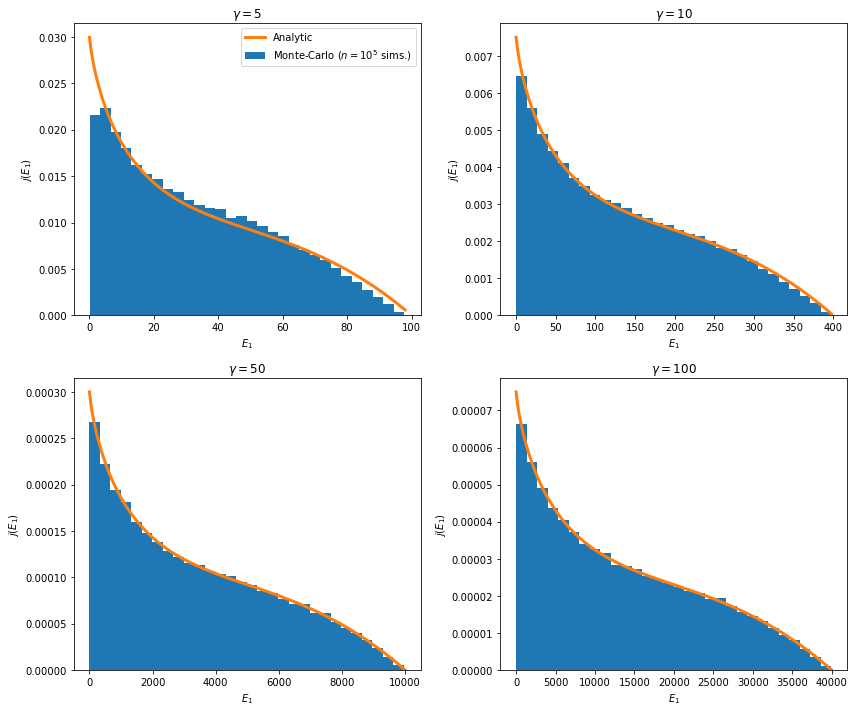

In [13]:
figD, axs = plt.subplots(2, 2, figsize=(12,10))
axs[0,0].hist(MC0, density=True, bins=30, label=r'Monte-Carlo ($n=10^5$ sims.)')
axs[0,0].plot(E1_values0, analytic0, lw=3, label='Analytic')
axs[0,0].set_title(r'$\gamma={:.0f}$'.format(Gamma0))
axs[0,0].set_xlabel(r'$E_1$')
axs[0,0].set_ylabel(r'$j(E_1)$')
axs[0,0].legend()

axs[0,1].hist(MC1, density=True, bins=30, label=r'Monte-Carlo ($n=10^5$ sims.)')
axs[0,1].plot(E1_values1, analytic1, lw=3, label='Analytic')
axs[0,1].set_title(r'$\gamma={:.0f}$'.format(Gamma1))
axs[0,1].set_xlabel(r'$E_1$')
axs[0,1].set_ylabel(r'$j(E_1)$')

axs[1,0].hist(MC2, density=True, bins=30, label=r'Monte-Carlo ($n=10^5$ sims.)')
axs[1,0].plot(E1_values2, analytic2, lw=3, label='Analytic')
axs[1,0].set_title(r'$\gamma={:.0f}$'.format(Gamma2))
axs[1,0].set_xlabel(r'$E_1$')
axs[1,0].set_ylabel(r'$j(E_1)$')

axs[1,1].hist(MC3, density=True, bins=30, label=r'Monte-Carlo ($n=10^5$ sims.)')
axs[1,1].plot(E1_values3, analytic3, lw=3, label='Analytic')
axs[1,1].set_title(r'$\gamma={:.0f}$'.format(Gamma3))
axs[1,1].set_xlabel(r'$E_1$')
axs[1,1].set_ylabel(r'$j(E_1)$')
plt.tight_layout()
plt.show()

## Part 2. Comptonization of a blackbody spectrum

### e)

In [14]:
#### CONSTANTS ####
h = 4.135667696e-15/1000 # keV*s
c = 299792458*100 # cm/s
m_e = 511/c**2 # 511 kev/c^2

#### PARAMETERS ####
T_s = 0.1 # keV
T_e = 25 # keV
a = np.sqrt(T_e/m_e) # standard deviation for Maxwell-Boltzmann distribution
Emin = 0.005 # keV - for initial blackbody spectrum sampling
Emax = 500 # keV - for initial blackbody spectrum sampling

#### Sampling from a Planck blackbody distribution with inverse transform sampling

In [15]:
def inv_CDF_Planck(E_min, E_max, kT):
    '''
    Returns the interpolationg of the inverse of the CDF for a blackbody distribution with temperature kT in units of energy.
    '''
    zeta3 = special.zeta(3)
    CDF = lambda E: 15/np.pi**4 * (np.pi**4/15 + (E/kT)**3*np.log(1-np.exp(-E/kT)) - 3*(E/kT)**2*mpmath.polylog(2, np.exp(-E/kT)) - 6*(E/kT)*mpmath.polylog(3, np.exp(-E/kT)) - 6*mpmath.polylog(4, np.exp(-E/kT)))
#     CDF = lambda E: ((E/kT)**2*np.log(1-np.exp(-E/kT)) - 2*(E/kT)*mpmath.polylog(2, np.exp(-E/kT)) - 2*mpmath.polylog(3, np.exp(-E/kT)) - 2*zeta3)/(2*zeta3)
    
    xs = np.logspace(np.log10(E_min)-1,np.log10(E_max)+1,10000)
    CDF_xs = np.asarray([CDF(xi) for xi in xs])
    inv_CDF_interpolated = interpolate.interp1d(CDF_xs, xs)
    return inv_CDF_interpolated, CDF_xs

In [16]:
def inverse_transform_sampling(inv_CDF_interp, CDF_pts, N):
    '''
    Apply inverse transform sampling on the interpolated inverse CDF of the desired distribution.
    Randomly samples N values from the distribution.
    '''
    u = np.random.uniform(np.min(CDF_pts), np.max(CDF_pts), N)
    sampled_values = inv_CDF_interp(u).astype('float')
    return sampled_values

In [17]:
# Prepare the inverse CDF function for later use because it takes a while...
inv_CDF_Planck, CDF_pts_Planck = inv_CDF_Planck(Emin, Emax, T_s)

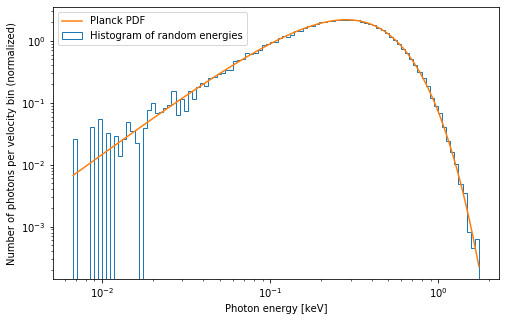

In [18]:
E_photons = inverse_transform_sampling(inv_CDF_Planck, CDF_pts_Planck, 100000)

Es_log = np.logspace(np.log10(E_photons.min()),np.log10(E_photons.max()),200)
PDF_Planck = lambda E, kT: 15*E**3/(np.pi**4*(kT)**4*(np.exp(E/kT)-1))
# nE_Planck = lambda E, kT: E**2/(2*special.zeta(3)*kT**3*(np.exp(E/kT)-1))

plt.figure(figsize=(8,5))
plt.hist(E_photons, density=True, bins=np.logspace(np.log10(E_photons.min()),np.log10(E_photons.max()),100), histtype='step', label='Histogram of random energies')
plt.plot(Es_log, PDF_Planck(Es_log, T_s), label='Planck PDF')
# plt.plot(Es_log, nE_Planck(Es_log, T_s))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Photon energy [keV]')
plt.ylabel('Number of photons per velocity bin (normalized)')
plt.legend()
plt.show()

#### Sampling from a Maxwell-Boltzmann energy distribution

In [19]:
def random_velocity_MB(a, N):
    '''
    Randomly sample N velocities from a Maxwell-Boltzmann distribution with standard deviation a = sqrt(kT/m).
    '''
    vx = np.random.normal(0, a, N)
    vy = np.random.normal(0, a, N)
    vz = np.random.normal(0, a, N)
    v = np.sqrt(vx**2 + vy**2 + vz**2)
    # Make sure there aren't any velocities larger than the speed of light. If there are, replace them with new velocities.
    idx = v >= c
    new_N = np.sum(idx)
    while new_N > 0: 
        new_vx = np.random.normal(0, a, new_N)
        new_vy = np.random.normal(0, a, new_N)
        new_vz = np.random.normal(0, a, new_N)
        new_vs = np.sqrt(new_vx**2 + new_vy**2 + new_vz**2)
        v[idx] = new_vs
        idx = v >= c
        new_N = np.sum(idx)
    return v

Max beta = 0.9981959520250638 -- Make sure no electrons are travelling faster than the speed of light.


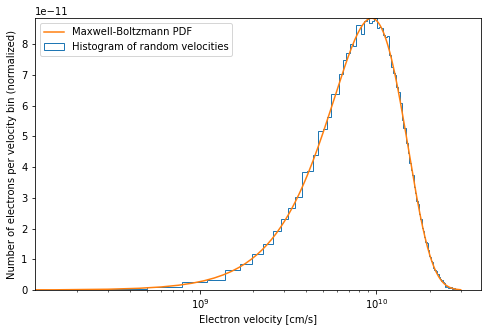

In [20]:
vs = random_velocity_MB(a, 100000)
print('Max beta =', vs.max()/c, '-- Make sure no electrons are travelling faster than the speed of light.')

v = np.linspace(0,3e10,200)

plt.figure(figsize=(8,5))
plt.hist(vs, density=True, bins=100, histtype='step', label='Histogram of random velocities')
plt.plot(v, np.sqrt(2/np.pi)*v**2*np.exp(-v**2/(2*a**2))/a**3, label='Maxwell-Boltzmann PDF')
plt.xscale('log')
plt.xlabel('Electron velocity [cm/s]')
plt.ylabel('Number of electrons per velocity bin (normalized)')
plt.legend()
plt.show()

#### Comptonize a blackbody spectrum!

In [21]:
#### WARNING: TAKES A WHILE ####
# Generate N random photon energies from a Planck distribution.
N_photons = 1000000
E_photon_i = inverse_transform_sampling(inv_CDF_Planck, CDF_pts_Planck, N_photons)

In [22]:
def Comptonize(tau, Ei):
    '''
    Comptonizes the input photon energies Ei.
    The number of Compton scatterings undergone by each photon is assumed to be the maximum of either tau^2 or tau.
        -- tau is the optical depth.  
    '''
    N = len(Ei) # number of photons
    N_scatterings = np.max([tau**2, tau])
    for i in range(N_scatterings):
        clear_output(wait=True)
        v_electron = random_velocity_MB(a, N) # sample N random electron velocities
        beta = v_electron/c
        lorentz = 1/np.sqrt(1-beta**2)
        
        mu = get_mu_labframe(beta, N) # sample N random photon directions
        Ei_rest = Ei*lorentz*(1-beta*mu) # transform photon energies to the electron rest frame
        
        cos_thetai_rest = (mu+beta)/(1+beta*mu) # transform photon directions to the electron rest frame
        thetai_rest = np.arccos(cos_thetai_rest)
        cos_alpha = get_cos_alpha(N) # sample N random scattering directions
        alpha = np.arccos(cos_alpha)    
        phi = np.random.uniform(0,2*np.pi,N) # sample N random angles phi around the beam's cone
        mu_rest = cos_alpha*cos_thetai_rest - np.sin(thetai_rest)*np.sin(alpha)*np.cos(phi) # calculate mu=cos(thetaf) in the electron rest frame
        
        Ef_rest = Ei_rest/(1+Ei_rest/511*(1-cos_alpha)) # Compton scatter the photon energies using the scattering angle (inelastic).
        Ef = Ef_rest*lorentz*(1+beta*mu_rest) # Transform the scattered photon energies back into the lab frame.
        Ei = Ef # Set the final photon energies from this iteration to be the initial photon energies of the next iteration.
        print('Progress:', np.round((i+1)/(N_scatterings)*100, 2), '%')
    return Ef

In [23]:
E_tau1 = Comptonize(1, E_photon_i)
E_tau3 = Comptonize(3, E_photon_i)
E_tau5 = Comptonize(5, E_photon_i)
E_tau7 = Comptonize(7, E_photon_i)
E_tau9 = Comptonize(9, E_photon_i)

Progress: 100.0 %


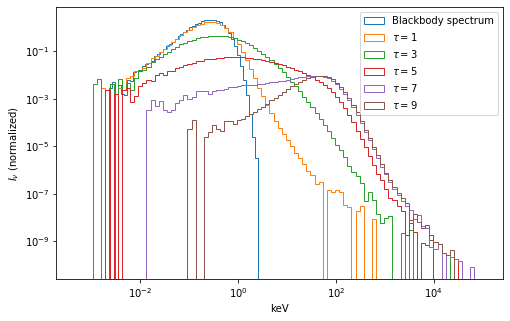

In [25]:
plt.figure(figsize=(8,5))
hist1 = plt.hist(E_photon_i, bins=np.logspace(np.log10(0.0005),np.log10(500),100), histtype='step', label='Blackbody spectrum', density=True)
hist2 = plt.hist(E_tau1, bins=np.logspace(np.log10(0.0005),np.log10(1e5),100), histtype='step', label=r'$\tau=1$', density=True)
hist3 = plt.hist(E_tau3, bins=np.logspace(np.log10(0.0005),np.log10(1e5),100), histtype='step', label=r'$\tau=3$', density=True)
hist4 = plt.hist(E_tau5, bins=np.logspace(np.log10(0.0005),np.log10(1e5),100), histtype='step', label=r'$\tau=5$', density=True)
hist5 = plt.hist(E_tau7, bins=np.logspace(np.log10(0.0005),np.log10(1e5),100), histtype='step', label=r'$\tau=7$', density=True)
hist6 = plt.hist(E_tau9, bins=np.logspace(np.log10(0.0005),np.log10(1e5),100), histtype='step', label=r'$\tau=9$', density=True)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('keV')
plt.ylabel(r'$I_\nu$ (normalized)')
plt.legend()
plt.show()